In [ ]:
<대략적인 개요>
# 입력을 평균과 분산 parameter로 인코딩
z_mean, z_log_variance = encoder(input_img)

# 무작위로 선택한 작은 epsilon 값을 사용해 잠재 공간의 포인트를 뽑는다.
z = z_mean + exp(z_log_variance) * epsilon
▶︎ z_log_var는 분산에 로그 적용한 것. 인코더 네트워크는 음수를 출력할 수도 있기 때문에 표준편차가 아니라 분산의 로그 값을 출력하도록 학습
VAE의 파라미터는 2개의 손실 함수로 훈련.
1. 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실(Cross-Entropy)
2. 잠재공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 규제 손실(Kullback-Leibler Divergence)

# z를 이미지로 디코딩
reconstructed_img = decoder(z)

# 모델 객체 생성
model = Model(input_img, reconstructed_img)

# 입력 이미지와 재구성 이미지를 매핑한 오토인코더 모델을 훈련합니다.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_11[0][0]                  
___________

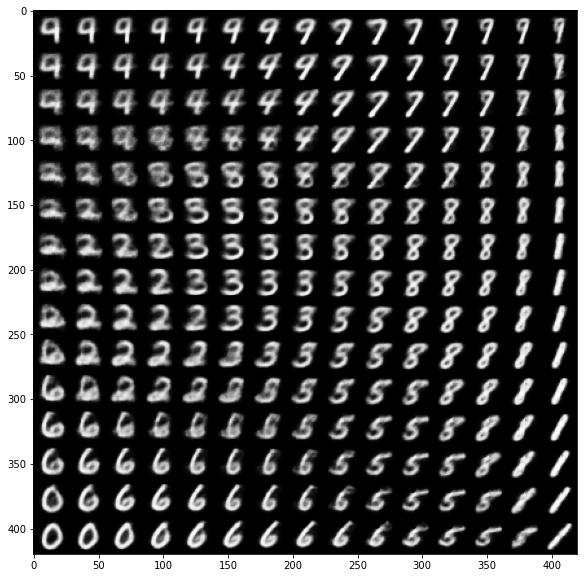

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from scipy.stats import norm

tf.compat.v1.disable_eager_execution()

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # 잠재 공간의 차원: 2D 평면


input_img = tf.keras.Input(shape=img_shape)



# 입력 이미지 x를 두 벡터 z_mean과 z_log_var로 매핑하는 컨브넷.
# VAE Encoder Network : 이미지를 잠재 공간 상의 확률 분포 파라미터로 매핑하는 인코더 네트워크.
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img) 
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
    # 인코더 네트워크가 음수를 출력할 수도 있기 떄문에 표준편차(exp(0.5*z_log_var))가 아닌 분산의 로그 값을 출력하도록 학습한다.


# 잠재 공간 샘플링 함수
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon # Reparametrization Trick

z = layers.Lambda(sampling)([z_mean, z_log_var])



# 잠재 공간 포인트를 이미지로 매핑하는 Decoder Network
decoder_input = layers.Input(K.int_shape(z)[1:]) # Input에 z 주입

x = layers.Dense(np.prod(shape_before_flattening[1:]),activation = 'relu')(decoder_input)
    # stride(2,2)를 사용했으므로 입력 이미지 크기가 절반으로 감소.(None, 14, 14, 64) / Upsampling : 14*14*64=12544
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation = 'relu', strides=(2,2))(x)
    # Conv2DTranspose는 zero-padding을 픽셀 주위로 배치해 Deconvolution과 같이 동작하며 업샘플링
x = layers.Conv2D(1, 3, padding='same', activation = 'sigmoid'XX)(x)

decoder = Model(decoder_input, x) # 디코더 모델 객체, VAE훈련시 인코더+디코더로 훈련, 잠재공간에서 샘플링&디코딩 할 때는 디코더만 사용
z_decoded = decoder(z) # 모델에 z를 주입하면 디코딩된 z를 출력



# VAE 손실을 계산하기 위한 레이어
    # 일반적인 샘플 기준의 함수인 loss(y_true, y_pred) 형태는 VAE의 이중 손실에 맞지 않는다.
    # add_loss 내장 메서드를 사용하여 추가된 손실은 vae.losses python 리스트에서 확인 가능, kl_loss 계산식의 상수 값이 0.5지만
    # 여기서는 규제 손실의 양을 조절하기 위해 0.0005를 사용
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        x_ent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(x_ent_loss + kl_loss)
    
    # 독자적인 층을 구현하려면 층의 가중치를 정의하는 build()메서드와 출력 텐서의 크기가 변경되었을 때 compute_output_shape 메서드를
    # 함께 구현해야 한다.
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # 출력을 사용하지는 않지만 Model 객체를 구현하기 위해 마지막 층에서 출력 텐서가 있어야 한다.
        
y = CustomVariationalLayer()([input_img, z_decoded])



# VAE Training
vae = Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x = x_train,
        y = None,
        shuffle = True,
        epochs = 10,
        batch_size = batch_size,
        validation_data = (x_test, None))



# 2D 잠재공간에서 포인트 그리드를 샘플링하여 이미지로 디코딩하기

n = 15 # (15*15 숫자의 그리드 출력)
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    # scipy ppf function : 백분위수를 전달하면 해당 포인트 값 리턴 / cdf()함수의 inverse

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        # xi, yi를 batch_size만큼 반복 후 (batch_size, 2)로 바꾼다.
        x_decoded = decoder.predict(z_sample, batch_size = batch_size)
        # predict 함수의 기본 배치사이즈는 32

        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size : (i+1)*digit_size, j*digit_size : (j+1)*digit_size] = digit

plt.figure(figsize=(10, 10)) # width, height in inches.
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [3]:
import numpy as np
from scipy.stats import norm
print(norm.ppf(np.linspace(0.05, 0.95, 15)))

[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
